## Импортируем необходимые библиотеки

In [2]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

## Создадим подключение к базе данных

In [3]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

## Сделаем запросы к базе данных

### Из таблицы checker

In [4]:
query="""
SELECT uid
FROM checker
WHERE uid LIKE 'user_%' AND
    labname <> 'project1';
"""

df_check = pd.read_sql(query, conn)
grouped = df_check.groupby('uid').size()
grouped_df = grouped.to_frame(name='num_commits')
check_df = grouped_df.sort_values('num_commits').reset_index()
check_df


,uid,num_commits
0,user_0,3
1,user_22,5
2,user_18,5
3,user_23,6
4,user_11,7
5,user_7,8
6,user_6,15
7,user_3,18
8,user_10,20
9,user_15,23


### Из таблицы pageviews

In [5]:
query2="""
SELECT uid
FROM pageviews
WHERE uid LIKE 'user_%';
"""

df_pg = pd.read_sql(query2, conn)
grouped = df_pg.groupby('uid').size()
grouped_df = grouped.to_frame(name='pageviews')
pg_df = grouped_df.sort_values('pageviews').reset_index()
pg_df

,uid,pageviews
0,user_5,1
1,user_9,2
2,user_18,3
3,user_30,3
4,user_21,10
5,user_19,16
6,user_1,28
7,user_17,47
8,user_10,89
9,user_14,143


## Создадим таблицу "test" и добавим ее в базу данных

In [6]:
query3 = """
SELECT checker.uid,
       checker.labname,
       checker.timestamp AS first_commit,
       pageviews.datetime AS first_view
FROM checker 
LEFT JOIN pageviews ON checker.uid=pageviews.uid
WHERE status='ready'
        AND numTrials=1
        AND labname IN ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s')
        AND checker.uid LIKE 'user_%'
        AND (pageviews.datetime = (SELECT MIN(pageviews.datetime)
                           FROM pageviews
                           WHERE uid=checker.uid)
                OR pageviews.datetime IS NULL)
"""

datamart = pd.read_sql(query3, conn, parse_dates=['first_commit', 'first_view'])
test = datamart[datamart['first_view'].notnull()]
test.to_sql('test', conn, if_exists='replace', index=False)

48

## Проверим, создалась ли новая таблица "test" в базе данных

In [7]:
tables = conn.cursor().execute('SELECT name from sqlite_master where type= "table"')
print(tables.fetchall())

[('pageviews',), ('checker',), ('deadlines',), ('test',)]


## Напишем запрос, который вычисляет среднюю разницу в часах между временем первого коммита (first_commit) и дедлайном лабораторной работы (deadlines)

In [8]:
query4 = """
SELECT uid,
       CAST((strftime('%s', test.first_commit) - deadlines.deadlines) / 3600 
            AS integer) AS avg_diff
FROM test
LEFT JOIN deadlines ON test.labname=deadlines.labs
"""
df_avr = pd.read_sql(query4, conn)
df_avr

,uid,avg_diff
0,user_30,-202
1,user_30,-201
2,user_14,-200
3,user_14,-193
4,user_19,-148
5,user_25,-148
6,user_21,-126
7,user_21,-99
8,user_28,-98
9,user_17,-81


In [9]:
avg_diff = df_avr.groupby(['uid']).mean().reset_index()
avg_diff

,uid,avg_diff
0,user_1,-64.400000
1,user_10,-74.800000
2,user_14,-159.000000
3,user_17,-61.600000
4,user_18,-5.666667
5,user_19,-98.750000
6,user_21,-95.500000
7,user_25,-92.600000
8,user_28,-86.400000
9,user_3,-105.400000


In [10]:
pivot_table = pg_df.merge(check_df, on=['uid'])
pivot_table = avg_diff.merge(pivot_table, on=['uid'])
pivot_table = pivot_table.drop(columns = ['uid'])
pivot_table


,avg_diff,pageviews,num_commits
0,-64.400000,28,62
1,-74.800000,89,20
2,-159.000000,143,61
3,-61.600000,47,51
4,-5.666667,3,5
5,-98.750000,16,118
6,-95.500000,10,65
7,-92.600000,179,79
8,-86.400000,149,60
9,-105.400000,317,18


## Построим график

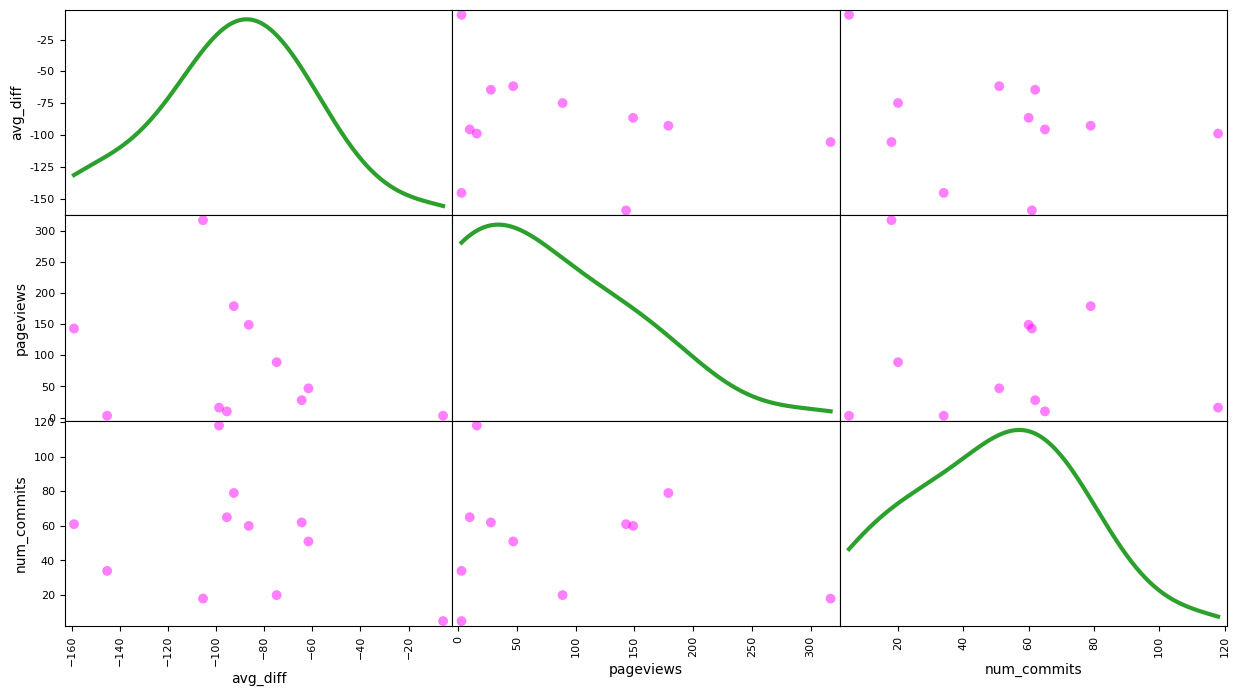

In [19]:
plt = scatter_matrix(pivot_table,
                    figsize=(15, 8),
                    diagonal='kde',
                    density_kwds=dict(color='#2ca02c', linewidth=3),
                    s=200,
                    color='#FF00FF')

## Подведём итоги

#### Можно ли сказать, что если у пользователя мало просмотров, то он, скорее всего, имеет небольшое количество коммитов?
**Ответ:** нет

#### Можем ли мы сказать, что если у пользователя мало просмотров, то он, скорее всего, имеет небольшую среднюю разницу между первым коммитом и дедлайном?
**Ответ:** нет



#### Можем ли мы сказать, что есть много пользователей с низким количеством коммитов и мало с высоким количеством коммитов? 

In [12]:
print(pivot_table['num_commits'].describe())

count     11.000000
mean      52.090909
std       31.957642
min        5.000000
25%       27.000000
50%       60.000000
75%       63.500000
max      118.000000
Name: num_commits, dtype: float64


**Ответ:** да
#### Можем ли мы сказать, что есть много пользователей с небольшими средними различиями и мало с большими средними различиями?


In [13]:
print(pivot_table['avg_diff'].describe())

count     11.000000
mean     -89.942424
std       41.209574
min     -159.000000
25%     -102.075000
50%      -92.600000
75%      -69.600000
max       -5.666667
Name: avg_diff, dtype: float64


Hаспределение средней разницы довольно равномерное, и нельзя выделить группу с явно небольшой разницей, так как значения достаточно сильно варьируются

**Ответ:** нет

## Закроем связь с базой данных

In [14]:
conn.close()